In [1]:
# %load_ext tensorboard
# fmt: off
from Interpretability.ModelAugmentation import *
from Interpretability.InterpretabilityMethods import *
from SequentialLearning.SequentialTasks.Stl10ClassificationTask import Stl10ClassificationTask as Task
from SequentialLearning.EWC_Methods.EWC_Methods import *

import os
import shutil
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
# fmt: on
print(tf.config.list_physical_devices('GPU'))

[]


In [2]:
MODEL_SAVE_PATH = "models/stl10_classification"
LOAD_MODEL = True
TRAIN_MODEL = not LOAD_MODEL

task_labels = [0,1]
model_input_shape = Task.IMAGE_SIZE
epochs = 10
training_batches = 0
validation_batches = 0
batch_size = 16
ewc_method = EWC_Method.FISHER_MATRIX

# Model Training and Architecture

In [3]:
model: tf.keras.Model
if LOAD_MODEL and os.path.exists(MODEL_SAVE_PATH):
    # Try to load model directly, if one exists
    print("LOADING MODEL")
    model = tf.keras.models.load_model(MODEL_SAVE_PATH)  # type: ignore
else:
    # Otherwise, make an entire new model!
    print("CREATING MODEL")
    model_inputs = model_layer = tf.keras.Input(shape=model_input_shape)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_0")(model_layer)
    model_layer = tf.keras.layers.MaxPool2D((2,2))(model_layer)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_1")(model_layer)
    model_layer = tf.keras.layers.MaxPool2D((2,2))(model_layer)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_2")(model_layer)
    model_layer = tf.keras.layers.MaxPool2D((2,2))(model_layer)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_3")(model_layer)
    model_layer = tf.keras.layers.Flatten()(model_layer)
    model_layer = tf.keras.layers.Dense(64, activation="relu")(model_layer)
    model_layer = tf.keras.layers.Dense(64, activation="relu")(model_layer)
    model_layer = tf.keras.layers.Dense(64, activation="relu")(model_layer)
    model_layer = tf.keras.layers.Dense(2)(model_layer)
    model = tf.keras.Model(inputs=model_inputs, outputs=model_layer, name="base_model")
if len(task_labels) == 2:
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
else:
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.summary()

LOADING MODEL
Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_0 (Conv2D)           (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20

In [4]:
task = Task(
        name=f"Task 0",
        model=model,
        model_base_loss=loss_fn,
        task_labels=task_labels,
        training_batches = 0,
        validation_batches = 0,
        batch_size=batch_size
    )
ewc_term_creator = EWC_Term_Creator(ewc_method, model, [task])

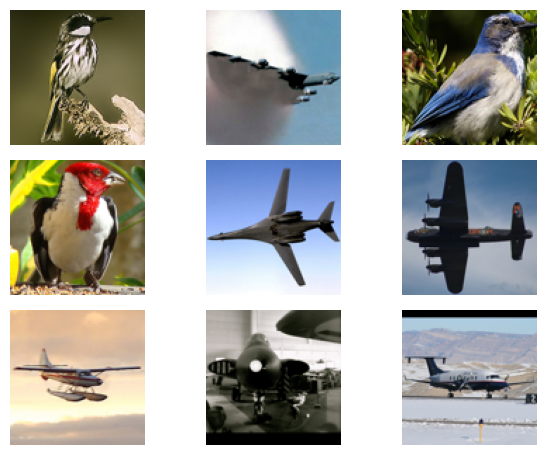

In [7]:
# Show some images from the task dataset
data = task.validation_dataset.take(1)
data_images, data_labels = data.as_numpy_iterator().next()
data_images = data_images[:9]
data_labels = data_labels[:9]
plot_images(data_images)

In [8]:
if TRAIN_MODEL:
    checkpoint_path = MODEL_SAVE_PATH+"/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=1)
    if os.path.isdir("./logs/TensorBoards"):
        shutil.rmtree("./logs/TensorBoards")
    history = task.train_on_task(epochs=epochs, callbacks=[
#         checkpoint_callback, 
        tf.keras.callbacks.TensorBoard(log_dir='./logs/TensorBoard'),
        *ewc_term_creator.callback_dict.values(),
    ])
    model.save(MODEL_SAVE_PATH)
else:
    print(f"{TRAIN_MODEL=}")
ewc_term = ewc_term_creator.create_term(ewc_lambda = 1)

TRAIN_MODEL=False
--------------------------------------------------------------------------------
STARTING FISHER CALCULATION
FINISHED FISHER CALCULATION
--------------------------------------------------------------------------------


In [19]:
threshold_model = threshold_model_by_omega(task.model, ewc_term.omega_matrix, 
    threshold_percentage = 0.8,
    comparison_method = ComparisonMethod.LAYER_WISE,
    aggregation_level = AggregationLevel.NO_AGGREGATION,
    aggregation_method = AggregationMethod.MEAN_AVERAGE,
)

LAYER_WISE layer_index=1 conv2d_0 threshold_value=1505.5837
LAYER_WISE layer_index=3 conv2d_1 threshold_value=45.853184
LAYER_WISE layer_index=5 conv2d_2 threshold_value=41.246597
LAYER_WISE layer_index=7 conv2d_3 threshold_value=31.821974
LAYER_WISE layer_index=9 dense threshold_value=0.100669615
LAYER_WISE layer_index=10 dense_1 threshold_value=0.8239503
LAYER_WISE layer_index=11 dense_2 threshold_value=0.7494332
LAYER_WISE layer_index=12 dense_3 threshold_value=49.142555


## Validation Testing

In [8]:
print(f"ORIGINAL  MODEL: {task.model.evaluate(task.validation_dataset, steps=task.validation_batches, return_dict=True)}")
print(f"THRESHOLD MODEL: {threshold_model.evaluate(task.validation_dataset, steps=task.validation_batches, return_dict=True)}")

100/100 [==============================] - 3s 12ms/step - loss: 0.2502 - base_loss: 0.2502
ORIGINAL  MODEL: {'loss': 0.2502064108848572, 'base_loss': 0.2502064108848572}
100/100 [==============================] - 2s 11ms/step - loss: 1.0610
THRESHOLD MODEL: {'loss': 1.0610473155975342}


# Interpretability Methods

## Kernel Inspection

OPERATING ON conv2d_1


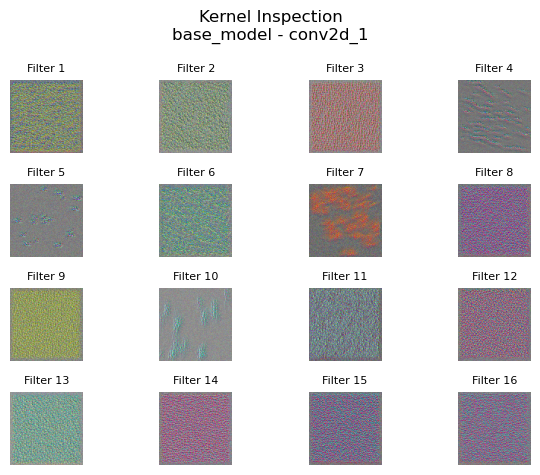

OPERATING ON conv2d_2


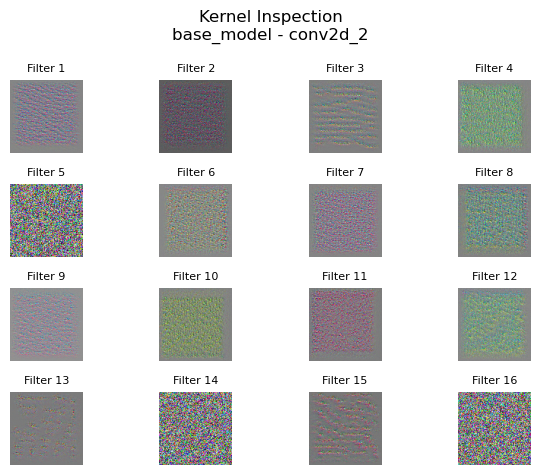

OPERATING ON conv2d_3


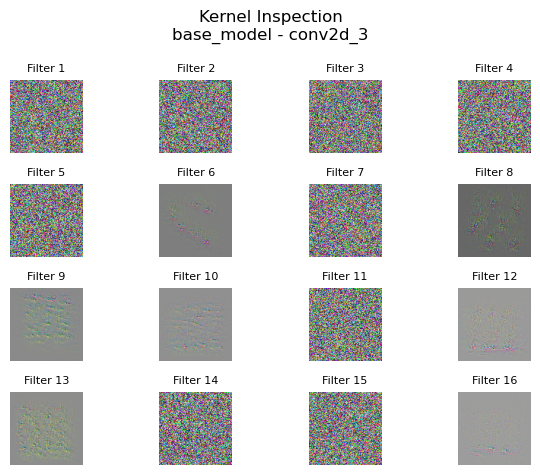

In [9]:
kernel_inspection(model=task.model, steps=100, step_size=0.01, layer_name="conv2d_1")
kernel_inspection(model=task.model, steps=100, step_size=0.05, layer_name="conv2d_2")
kernel_inspection(model=task.model, steps=100, step_size=0.05, layer_name="conv2d_3")

OPERATING ON conv2d_1


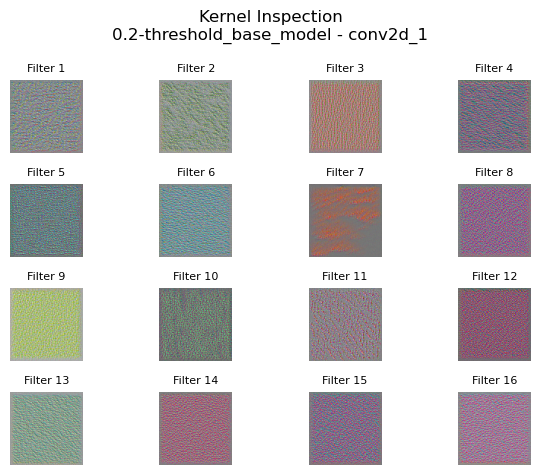

In [11]:
kernel_inspection(model=threshold_model, steps=100, step_size=0.05, layer_name="conv2d_1")
# kernel_inspection(model=threshold_model, steps=100, step_size=0.05, layer_name="conv2d_2")
# kernel_inspection(model=threshold_model, steps=100, step_size=0.05, layer_name="conv2d_3")

## Occlusion Sensitivity

IMAGE 1/9
PATCHES PROCESSED 8836 (93, 93)
IMAGE 2/9
PATCHES PROCESSED 8836 (93, 93)
IMAGE 3/9
PATCHES PROCESSED 8836 (93, 93)
IMAGE 4/9
PATCHES PROCESSED 8836 (93, 93)
IMAGE 5/9
PATCHES PROCESSED 8836 (93, 93)
IMAGE 6/9
PATCHES PROCESSED 8836 (93, 93)
IMAGE 7/9
PATCHES PROCESSED 8836 (93, 93)
IMAGE 8/9
PATCHES PROCESSED 8836 (93, 93)
IMAGE 9/9
PATCHES PROCESSED 8836 (93, 93)


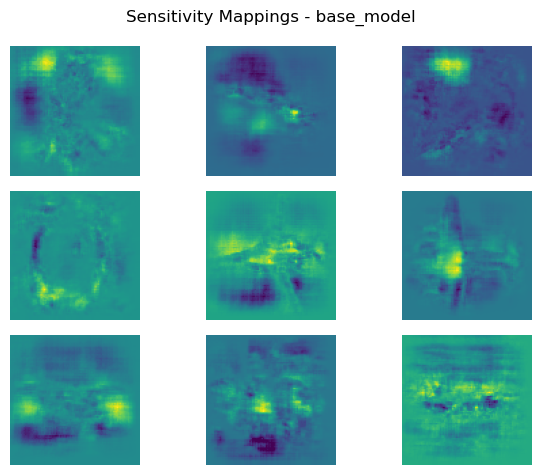

In [10]:
occlusion_sensitivity(task.model, data_images, data_labels, patch_size=3, stride=1, occlusion_batch_size=128)

In [ ]:
occlusion_sensitivity(threshold_model, data_images, data_labels, patch_size=2, stride=1)

## GRADCAM

HEATMAP RANGE (EXTREME): 0.2688295841217041
HEATMAP RANGE (AVG): 0.14602866768836975


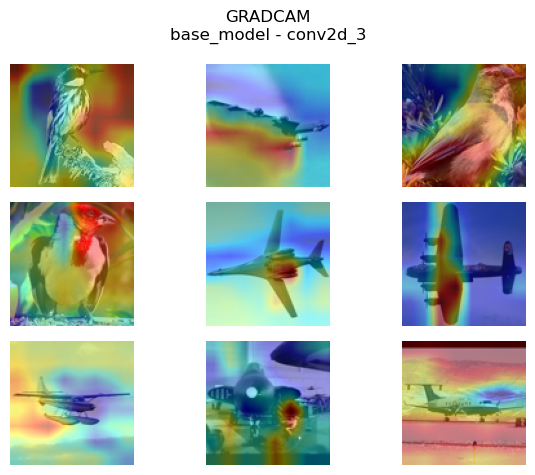

In [11]:
ALPHA = 0.6
BETA = 1-ALPHA

GRADCAM(task.model, data_images, data_labels, layer_name="conv2d_3",
    alpha=ALPHA, beta=BETA,
    show_predictions=0, absolute_scale=None)

HEATMAP RANGE (EXTREME): 0.007379412651062012
HEATMAP RANGE (AVG): 0.0020835266914218664


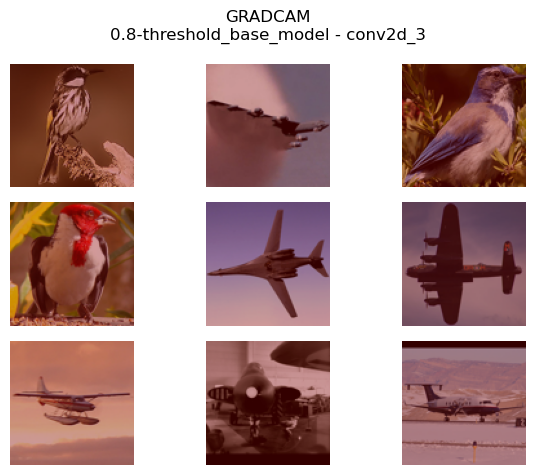

In [21]:
GRADCAM(threshold_model, data_images, data_labels, layer_name="conv2d_3", 
    alpha=ALPHA, beta=BETA,
    show_predictions=0, absolute_scale=0.26)